In [1]:
#-*- coding: utf-8 -*-

<img align="right" style="max-width: 200px; height: auto" src="images/cfds_logo.png">

###  Lab 07 - "Supervised Deep Learning - LSTMs"

Chartered Financial Data Scientist (CFDS), Spring Term 2019

In the sixth lab you learned about how to utilize an **unsupervised** (deep) learning technique namely **Convolutional Neural Networks (CNNs)** to classify tiny images of objects contained in the CIFAR-10 dataset.

In this seventh lab we will learn how to apply another type of deep learning technique referred to as **Long-Short-Term-Memory (LSTM)** neural networks. Unlike standard feedforward neural networks, LSTMs encompass feedback connections that make it a "general purpose computer". LSTMs are designed to not only process single data points (such as images), but also entire sequences of data, e.g., such as speech, video, or financial time series.


We will again use the functionality of the **'PyTorch'** library to implement and train an LSTM based neural network. The network will be trained on the historic daily (in-sample) returns of an exemplary financial stock. Once the network is trained, we will use the learned model to predict future (out-of-sample) returns. Finally, we will convert the predictions into tradable signals and the backtest the signals accordingly. 

The figure below illustrates a high-level eye view on the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 700px" src="images/process.png">

Pls. don't hesitate to contact me (via marco.schreyer@unisg.ch) in case of any difficulties with the lab content or any questions.

### Lab Objectives:

After today's lab you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Long-Short Term Memory (LSTM) Neural Networks**.
> 2. Know how to **implement and to train a LSTM** to learn a model of financial time-series data.
> 3. Understand how to apply such a learned model to **predict future data points of a time-series**.
> 4. Know how to **interpret the model's prediction results** and backtest the predictions. 

### Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the PyTorch, Numpy, Sklearn, Matplotlib, Seaborn, BT and a few utility libraries throughout the course of this lab:

In [2]:
# import python data science libraries
import os
import datetime as dt
import pandas as pd
import numpy as np

Import financial data science libraries:

In [3]:
import quandl as ql # library to retreive financial data
import bt as bt # library to backtest trading signals

Import python machine / deep learning libraries:

In [4]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import the sklearn pre-processing functions:

In [5]:
# sklearn libraries
from sklearn import preprocessing

Import python plotting libraries and set general plotting parameters:

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Enable notebook matplotlib inline plotting:

In [7]:
%matplotlib inline

Suppress potential warnings:

In [8]:
import warnings
warnings.filterwarnings('ignore')

Create notebook folder structure to store the data as well as the trained neural network models:

In [9]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

Set random seed value to obtain reproducable results:

In [10]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

### Step 1.0: Dataset Download and Data Assessment

In this section of the lab notebook we will download and access historic daily stock market data ranging from **01/01/2000** to **31/12/2017** of the **"International Business Machines" (IBM)** corporation (ticker symbol: "IBM"). In order to start the data download let's initialize the "quandl" financial data download API and set an API key:

In [11]:
ql.ApiConfig.api_key = '<enter you own quandl api code here>'

Furthermore, let's specify the start and end date of the stock market data download:

In [12]:
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2017, 12, 31)

Download the daily "International Business Machines" (IBM) stock market data:

In [13]:
stock_data = ql.get('WIKI/IBM', start_date=start_date, end_date=end_date, collapse='daily')

Inspect top 10 records of the retreived IBM stock market data:

In [14]:
stock_data.head(10)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,112.44,116.00,111.87,116.00,10347700.0,0.0,1.0,82.542051,85.155442,82.123614,85.155442,10347700.0
2000-01-04,114.00,114.50,110.87,112.06,8227800.0,0.0,1.0,83.687245,84.054294,81.389516,82.263093,8227800.0
2000-01-05,112.94,119.75,112.12,116.00,12733200.0,0.0,1.0,82.909100,87.908312,82.307139,85.155442,12733200.0
2000-01-06,118.00,118.94,113.50,114.00,7971900.0,0.0,1.0,86.623639,87.313692,83.320195,83.687245,7971900.0
2000-01-07,117.25,117.94,110.62,113.50,11856700.0,0.0,1.0,86.073065,86.579593,81.205991,83.320195,11856700.0
2000-01-10,117.25,119.37,115.37,118.00,8540500.0,0.0,1.0,86.073065,87.629354,84.692960,86.623639,8540500.0
2000-01-11,117.87,121.12,116.62,119.00,7873300.0,0.0,1.0,86.528206,88.914027,85.610583,87.357738,7873300.0
2000-01-12,119.62,122.00,118.25,119.50,6803800.0,0.0,1.0,87.812879,89.560034,86.807164,87.724787,6803800.0
2000-01-13,119.94,121.00,115.75,118.25,8489700.0,0.0,1.0,88.047790,88.825935,84.971917,86.807164,8489700.0


Let's also evaluate the data quality of the download by creating a set of summary statistics of the retrieved data:

In [15]:
stock_data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,4527.000000,4527.000000,4527.000000,4527.000000,4.527000e+03,4527.000000,4527.0,4527.000000,4527.000000,4527.000000,4527.000000,4.527000e+03
mean,128.222709,129.396728,127.159447,128.298614,6.278760e+06,0.009600,1.0,107.207865,108.166503,106.338592,107.269724,6.278760e+06
std,40.122937,40.198267,40.057692,40.137144,3.314386e+06,0.094086,0.0,40.589963,40.694568,40.490652,40.598655,3.314386e+06
min,54.650000,56.700000,54.010000,55.070000,1.027500e+06,0.000000,1.0,40.714758,42.242027,40.237952,41.027662,1.027500e+06
25%,92.270000,93.180000,91.500000,92.385000,4.023725e+06,0.000000,1.0,70.101463,70.880441,69.417812,70.119535,4.023725e+06
50%,119.310000,120.550000,117.850000,119.370000,5.502900e+06,0.000000,1.0,92.441676,93.664367,91.575772,92.473450,5.502900e+06
75%,161.935000,162.985000,160.845000,161.950000,7.644000e+06,0.000000,1.0,147.825960,148.985000,146.896456,147.799857,7.644000e+06
max,215.380000,215.900000,214.300000,215.800000,4.120730e+07,1.500000,1.0,186.042617,186.491787,185.109726,186.405408,4.120730e+07


Visually inspect the daily adjusted closing prices of the "International Business Machines" (IBM) stock market data:

Text(0.5, 1.0, 'International Business Machines (IBM) - Daily Adjusted Historical Stock Closing Prices')

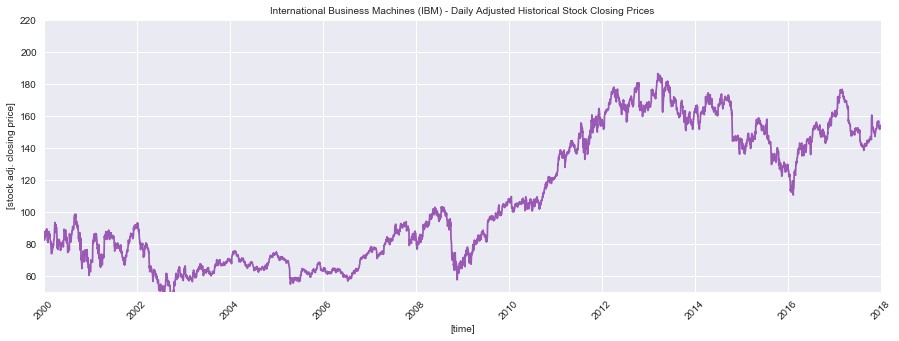

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.plot(stock_data.index, stock_data['Adj. Close'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[stock adj. closing price]', fontsize=10)
ax.set_ylim(50, 220)

# set plot title
plt.title('International Business Machines (IBM) - Daily Adjusted Historical Stock Closing Prices', fontsize=10)

Pls. note that we plotted the "adjusted" daily closing prices of the IBM stock. The stock prices are adjusted by the quandl team by several types of regular corporate actions, e.g., stock dividends, stock splits. For further details on the applied adjustments pls. refer to the following reference: https://blog.quandl.com/guide-to-stock-price-calculation

Save the obtained and validated stock market data to the local data directory:

In [17]:
# save retrieved data to local data directory
stock_data.to_csv('data/ibm_data_2010_2017_daily.csv', sep=';', encoding='utf-8')

### Step 2.0: Data Pre-Processing

In this section we will obtain daily returns of the retrieved daily adjusted closing prices. In addition we will convert the time-series of daily returns into a set of sequences $s$ of $n$ time steps respectively. The created sequences will then be used to learn a model using an LSTM based neural network.

#### Step 2.1: Daily Returns Calculation

Determine the daily returns of the "International Business Machines" (IBM) daily adjusted closing prices:

In [18]:
stock_data['RETURN'] = stock_data['Adj. Close'].pct_change()

Visually inspect the obtained daily returns:

Text(0.5, 1.0, 'International Business Machines (IBM) - Daily Historical Stock Closing Prices')

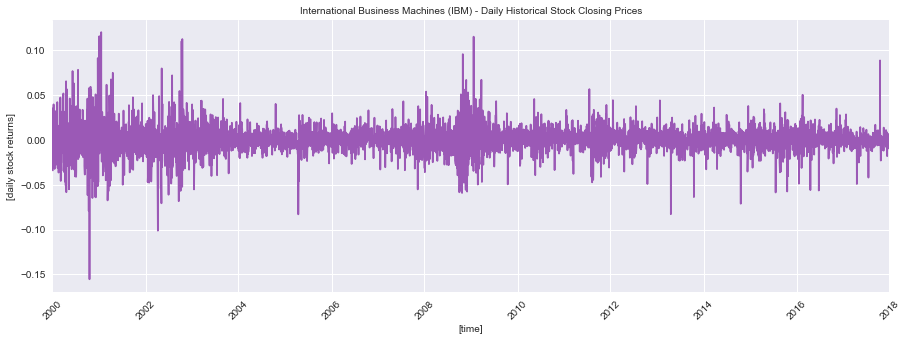

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.plot(stock_data.index, stock_data['RETURN'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[daily stock returns]', fontsize=10)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Closing Prices', fontsize=10)

#### Step 2.2: Transform Time-Series Into Sequences

Set the number of time-steps $n$ each individual sequence $s^{i}$ should be comprised of:

In [20]:
# number of timesteps
sequence_length = 5

Remove the initial return of the return time-series which is usually not applicable and therefore 'nan':

In [21]:
stock_daily_returns = stock_data['RETURN'][1:len(stock_data['RETURN'])]

Extract individual time sequences of length $n$ from the obtained daily returns:

In [22]:
# iterate over distinct normalized closing prices
for i in range(0, stock_daily_returns.shape[0] - sequence_length):

    # extract normalized closing price sequence 
    single_stock_sequence_data = stock_daily_returns[i:i + sequence_length].T

    # case: initial sequence
    if i == 0:

        # convert to numpy array and collect sequence of normalized closing prices
        stock_sequence_data = np.array(single_stock_sequence_data)

    # case: non-initial sequence
    else:

        # convert to numpy array and collect sequence of normalized closing prices
        stock_sequence_data  = np.vstack((stock_sequence_data , np.array(single_stock_sequence_data)))

Inspect the top five collected normalized daily closing prices sequences:

In [23]:
stock_sequence_data[0:5,]

array([[-0.03396552,  0.03515974, -0.01724138, -0.00438596,  0.03964758],
       [ 0.03515974, -0.01724138, -0.00438596,  0.03964758,  0.00847458],
       [-0.01724138, -0.00438596,  0.03964758,  0.00847458,  0.00420168],
       [-0.00438596,  0.03964758,  0.00847458,  0.00420168, -0.01046025],
       [ 0.03964758,  0.00847458,  0.00420168, -0.01046025,  0.01158562]])

#### Step 2.3: Prepare Sequences for Neural Network Training

Set split fraction to split return sequences into training (in-sample) and validation (out-of-sample) sequences:

In [24]:
split_fraction = 0.9
split_row = int(stock_sequence_data.shape[0] * split_fraction)

Split obtained return sequences into training (in-sample) sequences $s^{i}_{train}$ and validation (out-of-sample) sequences $s^{i}_{valid}$:

In [25]:
train_sequences = stock_sequence_data[:split_row,]
valid_sequences = stock_sequence_data[split_row:,]

Determine count (shape) of adjusted daily return train sequences $s^{i}_{train}$:

In [26]:
train_sequences.shape

(4068, 5)

Determine count (shape) of adjusted daily return train sequences $s^{i}_{valid}$:

In [27]:
valid_sequences.shape

(453, 5)

Seperate each training sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{train, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{train, target}=r_{t+1}$. In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [28]:
train_sequences_input = torch.from_numpy(train_sequences[:, :-1]).float()
train_sequences_target = torch.from_numpy(train_sequences[:, 1:]).float()

Seperate each validation sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{valid, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{valid, target}=r_{t+1}$. In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [29]:
valid_sequences_input = torch.from_numpy(valid_sequences[:, :-1]).float()
valid_sequences_target = torch.from_numpy(valid_sequences[:, 1:]).float()

In order to train a LSTM neural network, we tailor the dataset class provided by the PyTorch library. We overwrite the individual functions of the dataset class. So that our dataset will supply the neural network with the individual training sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$ throughout the training process:

In [30]:
# define daily returns dataset
class DailyReturnsDataset(data.Dataset):

    # define class constructor
    def __init__(self, sequences, targets):

        # init sequences and corresponding targets
        self.sequences = sequences
        self.targets = targets

    # define length method 
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define get item method
    def __getitem__(self, index):

        # determine single sequence and corresponding target
        sequence = self.sequences[index, :]
        target = self.targets[index, :]

        # return sequences and target
        return sequence, target

Once we have specified the daily returns dataset class we instantiate it using the new daily closing dataset using the prepared training input sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$: 

In [31]:
train_dataset = DailyReturnsDataset(train_sequences_input, train_sequences_target)

Let's see how it works by getting the 10th sequence and its corresponding targets:

In [32]:
train_dataset.__getitem__(10)

(tensor([ 0.0324, -0.0042,  0.0210,  0.0000]),
 tensor([-0.0042,  0.0210,  0.0000, -0.0196]))

### Step 3.0 Neural Network Implementation and Loss Function

In this section we will implement the LSTM architecture of the to be learned time series model. Furthermore, we will specify the loss-function, learning-rate and optimization technique used in the network training.

#### Step 3.1: Implementation of the LSTM Architecture

In this section we will implement the architecture of the LSTM neural network we want to utilize in order to predict future returns of our financial time series data. The neural network, which we name **'LSTM_NN'** consists in total of three layers. The first two layers correspond to LSTM cells while the third layer corresponds to a fully-connected linear layer. The individual gates of the LSTM cell are calculated according to the following functions:

<center> 
$i=σ(W_{ii}x+b_{ii}+W_{hi}h+b_{hi}), \\
f=σ(W_{if}x+b_{if}+W_{hf}h+b_{hf}), \\
g=tanh(W_{ig}x+b_{ig}+W_{hg}h+b_{hg}), \\
o=σ(W_{io}x+b_{io}+W_{ho}h+b_{ho}), \\
c′=f∗c+i∗g, \\
h′=o∗tanh(c′).$ 
</center>

(Source: https://pytorch.org/docs/stable/nn.html)

Each of the two LSTM cells exhibit a hidden state 51 dimensions. The third linear squeezes the 51 hidden state dimensions of the second (last) LSTM cell into a single output dimension. The single output signal of the linear layer  refers to the future return predicted by the neural network. 

In [33]:
# implement the LSTMNet network architecture
class LSTMNet(nn.Module):

    # define class constructor
    def __init__(self):

        super(LSTMNet, self).__init__()

        # define lstm nn architecture
        self.lstm1 = nn.LSTMCell(1, 51)  # first lstm layer
        self.lstm2 = nn.LSTMCell(51, 51)  # second lstm layer
        self.linear = nn.Linear(51, 1)  # final linear layer

    # define network forward pass
    def forward(self, input):

        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)

        # init the lstm cell states
        c_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)
        
        # iterate over distinct time steps
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            # propagate through time step data
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            prediction = self.linear(h_t2)
            
            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

Now, that we have implemented our first neural network we are ready to instantiate a model to be trained:

In [34]:
lstm_model = LSTMNet()

Once the model is initialized, we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [35]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(lstm_model))

[LOG] MNISTNet architecture:

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)



Looks like intended? Great!

#### Step 3.2: Definition of the Training Loss Function and Learning Rate

We are now good to train the network. However, prior to starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the prediction error of the true return $r_{t+1}$ and the by the model predicted return $\hat{r}_{t+1}$ at a given time-step $t+1$ of sequence $s^{i}$. In other words, for a given sequence of historic returns we aim to learn a function $f_\theta$ that is capable to predicts the return of the next timestep as faithfully as possible, as expressed by:

<center> $\hat{r}_{t+1} = f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})$. </center>

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\min_{\theta} \|r_{t+1} - f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})\|$ over all time-steps $t$ contained in the set of training sequences $s_{train}$. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ while training the neural network. In this lab we use the **'Mean Squared Error (MSE)'** loss, as denoted by:

<center> $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, </center>

In [36]:
loss_function = nn.MSELoss()

Throughout the training process the PyTorch library will automatically calculate the loss magnitude, compute the gradient, and update the parameters $\theta$ of the LSTM neural network. We will use the **"Adaptive Moment Estimation Optimization" (ADAM)** technique to optimize the network parameters. Furthermore, we specify a constant learning rate of $l = 1e-06$. For each training step the optimizer will update the model parameters $\theta$ values according to degree of prediction error (the MSE loss).

In [37]:
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

Now that we have successfully implemented and defined the three ANN building blocks let's take some time to review the `LSTMNet` model definition as well as the `MSE loss` function. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

### Step 4.0. Training the Neural Network Model

In this section, we will train the LSTM neural network model (as implemented in the section above) using the prepared dataset of daily return sequences. Therefore, we will have a detailed look into the distinct training steps and monitor the training progress.

#### Step 4.1. Preparing the Network Training

Let's now start to learn a model by training the NN for `2'000 epochs` in `mini-batches of size of 128 sequences` per batch. This implies that the whole dataset will be fed to the NN 2'000 times in chunks of 128 sequences yielding to `32 mini-batches` (4'068 training sequences / 128 sequences per mini-batch) per epoch:

In [38]:
# specify the training parameters
num_epochs = 2000 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [39]:
dataloader = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0)

#### Step 4.2. Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows: 

>1. do a forward pass through the LSTMNet network, 
>2. compute the mean-squared prediction error $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, 
>3. do a backward pass through the LSTMNet network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training the LSTM model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the mean prediction performance over all mini-batches in each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [40]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# init the best loss
best_loss = 100.00

# iterate over epochs
for epoch in range(0, num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
            
    # iterate over mini-batches
    for sequence_batch, target_batch in dataloader:

        # predict sequence output
        prediction_batch = lstm_model(sequence_batch)

        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()
        
        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())
            
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
        
    # print epoch and save models
    if epoch % 10 == 0 and epoch > 0:
        
        # case: new best model trained
        if train_epoch_loss < best_loss:
                        
            # store new best model
            model_name = 'awsome_lstm_model_{}.pth'.format(str(epoch))
            torch.save(lstm_model.state_dict(), os.path.join("./models", model_name))
            
            # update best loss
            best_loss = train_epoch_loss
            
            # print epoch loss
            now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[LOG {}] epoch: {} new best train-loss: {} found'.format(str(now), str(epoch), str(train_epoch_loss)))


[LOG 20190630-20:37:17] epoch: 0 train-loss: 0.0036956439798814245
[LOG 20190630-20:37:17] epoch: 1 train-loss: 0.003645348668214865
[LOG 20190630-20:37:18] epoch: 2 train-loss: 0.0035876172696589492
[LOG 20190630-20:37:18] epoch: 3 train-loss: 0.0035272282184450887
[LOG 20190630-20:37:19] epoch: 4 train-loss: 0.0034660340897971764
[LOG 20190630-20:37:19] epoch: 5 train-loss: 0.003404784933081828
[LOG 20190630-20:37:20] epoch: 6 train-loss: 0.0033438507962273434
[LOG 20190630-20:37:20] epoch: 7 train-loss: 0.0032834291414474137
[LOG 20190630-20:37:21] epoch: 8 train-loss: 0.0032236410115729086
[LOG 20190630-20:37:21] epoch: 9 train-loss: 0.0031645568960811943
[LOG 20190630-20:37:22] epoch: 10 train-loss: 0.00310622916003922
[LOG 20190630-20:37:22] epoch: 10 new best train-loss: 0.00310622916003922 found
[LOG 20190630-20:37:22] epoch: 11 train-loss: 0.0030486889227177016
[LOG 20190630-20:37:23] epoch: 12 train-loss: 0.0029919592416263185
[LOG 20190630-20:37:23] epoch: 13 train-loss: 0.0

[LOG 20190630-20:38:08] epoch: 109 train-loss: 0.0006163620319057372
[LOG 20190630-20:38:09] epoch: 110 train-loss: 0.0006156018444016809
[LOG 20190630-20:38:09] epoch: 110 new best train-loss: 0.0006156018444016809 found
[LOG 20190630-20:38:09] epoch: 111 train-loss: 0.0006151856450742343
[LOG 20190630-20:38:10] epoch: 112 train-loss: 0.0006151097904876224
[LOG 20190630-20:38:10] epoch: 113 train-loss: 0.0006153704453026876
[LOG 20190630-20:38:11] epoch: 114 train-loss: 0.0006159639469842659
[LOG 20190630-20:38:11] epoch: 115 train-loss: 0.0006168863501443411
[LOG 20190630-20:38:11] epoch: 116 train-loss: 0.0006181337757880101
[LOG 20190630-20:38:12] epoch: 117 train-loss: 0.0006197021602929453
[LOG 20190630-20:38:12] epoch: 118 train-loss: 0.0006215876364876749
[LOG 20190630-20:38:13] epoch: 119 train-loss: 0.000623786031610507
[LOG 20190630-20:38:13] epoch: 120 train-loss: 0.0006262934311962454
[LOG 20190630-20:38:14] epoch: 121 train-loss: 0.0006291056479312829
[LOG 20190630-20:38:

[LOG 20190630-20:39:03] epoch: 227 train-loss: 0.0014393800811376423
[LOG 20190630-20:39:04] epoch: 228 train-loss: 0.0014375186256074812
[LOG 20190630-20:39:04] epoch: 229 train-loss: 0.0014353060796565842
[LOG 20190630-20:39:04] epoch: 230 train-loss: 0.001432746576028876
[LOG 20190630-20:39:05] epoch: 231 train-loss: 0.0014298442474682815
[LOG 20190630-20:39:05] epoch: 232 train-loss: 0.0014266024772950914
[LOG 20190630-20:39:06] epoch: 233 train-loss: 0.0014230258420866448
[LOG 20190630-20:39:06] epoch: 234 train-loss: 0.0014191190311976243
[LOG 20190630-20:39:07] epoch: 235 train-loss: 0.001414886733982712
[LOG 20190630-20:39:07] epoch: 236 train-loss: 0.0014103337634878699
[LOG 20190630-20:39:08] epoch: 237 train-loss: 0.0014054650273465086
[LOG 20190630-20:39:08] epoch: 238 train-loss: 0.0014002865900692996
[LOG 20190630-20:39:09] epoch: 239 train-loss: 0.001394803239236353
[LOG 20190630-20:39:09] epoch: 240 train-loss: 0.0013890208247175906
[LOG 20190630-20:39:10] epoch: 241 tr

[LOG 20190630-20:39:57] epoch: 343 train-loss: 0.00045930196029075887
[LOG 20190630-20:39:58] epoch: 344 train-loss: 0.00045559525324279093
[LOG 20190630-20:39:58] epoch: 345 train-loss: 0.0004520377160588396
[LOG 20190630-20:39:59] epoch: 346 train-loss: 0.0004486282145990117
[LOG 20190630-20:39:59] epoch: 347 train-loss: 0.0004453654960343556
[LOG 20190630-20:40:00] epoch: 348 train-loss: 0.00044224810790183255
[LOG 20190630-20:40:00] epoch: 349 train-loss: 0.0004392754181026248
[LOG 20190630-20:40:01] epoch: 350 train-loss: 0.00043644614379445557
[LOG 20190630-20:40:01] epoch: 350 new best train-loss: 0.00043644614379445557 found
[LOG 20190630-20:40:01] epoch: 351 train-loss: 0.0004337583882261242
[LOG 20190630-20:40:02] epoch: 352 train-loss: 0.0004312110818318615
[LOG 20190630-20:40:02] epoch: 353 train-loss: 0.0004288029535928217
[LOG 20190630-20:40:03] epoch: 354 train-loss: 0.00042653233413147973
[LOG 20190630-20:40:03] epoch: 355 train-loss: 0.0004243977618898498
[LOG 20190630

[LOG 20190630-20:40:56] epoch: 458 train-loss: 0.0005216054423726746
[LOG 20190630-20:40:56] epoch: 459 train-loss: 0.0005220858092798153
[LOG 20190630-20:40:57] epoch: 460 train-loss: 0.0005225238364801044
[LOG 20190630-20:40:57] epoch: 461 train-loss: 0.0005229231182966032
[LOG 20190630-20:40:58] epoch: 462 train-loss: 0.000523281690220756
[LOG 20190630-20:40:58] epoch: 463 train-loss: 0.0005236025026533753
[LOG 20190630-20:40:59] epoch: 464 train-loss: 0.0005238856901996769
[LOG 20190630-20:40:59] epoch: 465 train-loss: 0.0005241328926786082
[LOG 20190630-20:41:00] epoch: 466 train-loss: 0.0005243442801656784
[LOG 20190630-20:41:01] epoch: 467 train-loss: 0.0005245212887530215
[LOG 20190630-20:41:01] epoch: 468 train-loss: 0.0005246644059297978
[LOG 20190630-20:41:01] epoch: 469 train-loss: 0.0005247756425887928
[LOG 20190630-20:41:02] epoch: 470 train-loss: 0.0005248550669421093
[LOG 20190630-20:41:02] epoch: 471 train-loss: 0.000524904307894758
[LOG 20190630-20:41:03] epoch: 472 t

[LOG 20190630-20:41:57] epoch: 576 train-loss: 0.00039065921100700507
[LOG 20190630-20:41:58] epoch: 577 train-loss: 0.0003886346066792612
[LOG 20190630-20:41:58] epoch: 578 train-loss: 0.0003866209840452939
[LOG 20190630-20:41:59] epoch: 579 train-loss: 0.00038461981057480443
[LOG 20190630-20:41:59] epoch: 580 train-loss: 0.00038263004762484343
[LOG 20190630-20:41:59] epoch: 580 new best train-loss: 0.00038263004762484343 found
[LOG 20190630-20:42:00] epoch: 581 train-loss: 0.00038065379794716137
[LOG 20190630-20:42:01] epoch: 582 train-loss: 0.0003786921147366229
[LOG 20190630-20:42:01] epoch: 583 train-loss: 0.0003767439620787627
[LOG 20190630-20:42:02] epoch: 584 train-loss: 0.0003748108188119659
[LOG 20190630-20:42:02] epoch: 585 train-loss: 0.0003728941487679549
[LOG 20190630-20:42:03] epoch: 586 train-loss: 0.0003709926313604228
[LOG 20190630-20:42:03] epoch: 587 train-loss: 0.0003691079027703381
[LOG 20190630-20:42:04] epoch: 588 train-loss: 0.00036724115943798097
[LOG 20190630

[LOG 20190630-20:42:54] epoch: 682 train-loss: 0.0002919009314155119
[LOG 20190630-20:42:55] epoch: 683 train-loss: 0.0002920564515989099
[LOG 20190630-20:42:55] epoch: 684 train-loss: 0.00029222604280221276
[LOG 20190630-20:42:56] epoch: 685 train-loss: 0.00029240945377750904
[LOG 20190630-20:42:57] epoch: 686 train-loss: 0.0002926064778421278
[LOG 20190630-20:42:57] epoch: 687 train-loss: 0.0002928167036770901
[LOG 20190630-20:42:58] epoch: 688 train-loss: 0.00029303983842510206
[LOG 20190630-20:42:58] epoch: 689 train-loss: 0.00029327591255423613
[LOG 20190630-20:42:59] epoch: 690 train-loss: 0.00029352471824495296
[LOG 20190630-20:42:59] epoch: 691 train-loss: 0.0002937857266260835
[LOG 20190630-20:43:00] epoch: 692 train-loss: 0.00029405851864794386
[LOG 20190630-20:43:01] epoch: 693 train-loss: 0.00029434309840326023
[LOG 20190630-20:43:01] epoch: 694 train-loss: 0.0002946393251477275
[LOG 20190630-20:43:02] epoch: 695 train-loss: 0.0002949469701434282
[LOG 20190630-20:43:02] epo

[LOG 20190630-20:44:01] epoch: 801 train-loss: 0.0003478033336250519
[LOG 20190630-20:44:02] epoch: 802 train-loss: 0.00034820018663594965
[LOG 20190630-20:44:03] epoch: 803 train-loss: 0.0003485908516722702
[LOG 20190630-20:44:03] epoch: 804 train-loss: 0.00034897478462880827
[LOG 20190630-20:44:04] epoch: 805 train-loss: 0.00034935097846755525
[LOG 20190630-20:44:04] epoch: 806 train-loss: 0.0003497193531529774
[LOG 20190630-20:44:05] epoch: 807 train-loss: 0.00035008072723030637
[LOG 20190630-20:44:05] epoch: 808 train-loss: 0.0003504348210299213
[LOG 20190630-20:44:06] epoch: 809 train-loss: 0.0003507818835259968
[LOG 20190630-20:44:06] epoch: 810 train-loss: 0.00035112122282043856
[LOG 20190630-20:44:07] epoch: 811 train-loss: 0.00035145261290381313
[LOG 20190630-20:44:08] epoch: 812 train-loss: 0.0003517748373269569
[LOG 20190630-20:44:08] epoch: 813 train-loss: 0.00035208916870033136
[LOG 20190630-20:44:09] epoch: 814 train-loss: 0.0003523951704664796
[LOG 20190630-20:44:09] epo

[LOG 20190630-20:45:07] epoch: 920 train-loss: 0.00033464947568973
[LOG 20190630-20:45:07] epoch: 921 train-loss: 0.00033426131267333403
[LOG 20190630-20:45:08] epoch: 922 train-loss: 0.00033387479970770073
[LOG 20190630-20:45:08] epoch: 923 train-loss: 0.00033349014188388537
[LOG 20190630-20:45:09] epoch: 924 train-loss: 0.00033310725393675966
[LOG 20190630-20:45:09] epoch: 925 train-loss: 0.00033272687164753734
[LOG 20190630-20:45:10] epoch: 926 train-loss: 0.0003323486894259986
[LOG 20190630-20:45:10] epoch: 927 train-loss: 0.0003319729353279399
[LOG 20190630-20:45:11] epoch: 928 train-loss: 0.00033159933377646666
[LOG 20190630-20:45:11] epoch: 929 train-loss: 0.00033122818467745674
[LOG 20190630-20:45:12] epoch: 930 train-loss: 0.00033085945642596926
[LOG 20190630-20:45:12] epoch: 931 train-loss: 0.00033049332478185534
[LOG 20190630-20:45:13] epoch: 932 train-loss: 0.0003301299209397257
[LOG 20190630-20:45:14] epoch: 933 train-loss: 0.0003297694086086267
[LOG 20190630-20:45:14] epo

[LOG 20190630-20:46:09] epoch: 1038 train-loss: 0.00031274583102458564
[LOG 20190630-20:46:09] epoch: 1039 train-loss: 0.0003127579775537015
[LOG 20190630-20:46:10] epoch: 1040 train-loss: 0.00031277236735149927
[LOG 20190630-20:46:10] epoch: 1041 train-loss: 0.0003127887150640163
[LOG 20190630-20:46:11] epoch: 1042 train-loss: 0.0003128070543425565
[LOG 20190630-20:46:11] epoch: 1043 train-loss: 0.00031282754366657173
[LOG 20190630-20:46:12] epoch: 1044 train-loss: 0.0003128499295144138
[LOG 20190630-20:46:13] epoch: 1045 train-loss: 0.0003128741329874174
[LOG 20190630-20:46:13] epoch: 1046 train-loss: 0.0003129002382138424
[LOG 20190630-20:46:14] epoch: 1047 train-loss: 0.0003129281310521037
[LOG 20190630-20:46:15] epoch: 1048 train-loss: 0.00031295780422624375
[LOG 20190630-20:46:15] epoch: 1049 train-loss: 0.00031298923977374216
[LOG 20190630-20:46:16] epoch: 1050 train-loss: 0.00031302232355301385
[LOG 20190630-20:46:16] epoch: 1051 train-loss: 0.00031305697552852507
[LOG 20190630

[LOG 20190630-20:47:10] epoch: 1155 train-loss: 0.0003192704016328207
[LOG 20190630-20:47:11] epoch: 1156 train-loss: 0.00031931853391142795
[LOG 20190630-20:47:11] epoch: 1157 train-loss: 0.0003193662096236949
[LOG 20190630-20:47:12] epoch: 1158 train-loss: 0.0003194134401383053
[LOG 20190630-20:47:12] epoch: 1159 train-loss: 0.00031946016770234564
[LOG 20190630-20:47:13] epoch: 1160 train-loss: 0.0003195064311967144
[LOG 20190630-20:47:13] epoch: 1161 train-loss: 0.0003195522692749364
[LOG 20190630-20:47:14] epoch: 1162 train-loss: 0.00031959768034539593
[LOG 20190630-20:47:14] epoch: 1163 train-loss: 0.00031964262370820506
[LOG 20190630-20:47:14] epoch: 1164 train-loss: 0.00031968711209628964
[LOG 20190630-20:47:15] epoch: 1165 train-loss: 0.00031973116597328044
[LOG 20190630-20:47:15] epoch: 1166 train-loss: 0.00031977477533473575
[LOG 20190630-20:47:16] epoch: 1167 train-loss: 0.0003198179122136935
[LOG 20190630-20:47:16] epoch: 1168 train-loss: 0.0003198605807028798
[LOG 20190630

[LOG 20190630-20:48:04] epoch: 1272 train-loss: 0.0003216855159280385
[LOG 20190630-20:48:05] epoch: 1273 train-loss: 0.0003216809686819033
[LOG 20190630-20:48:05] epoch: 1274 train-loss: 0.00032167615108846803
[LOG 20190630-20:48:06] epoch: 1275 train-loss: 0.00032167103995561774
[LOG 20190630-20:48:06] epoch: 1276 train-loss: 0.0003216656607492041
[LOG 20190630-20:48:07] epoch: 1277 train-loss: 0.00032166000301003805
[LOG 20190630-20:48:08] epoch: 1278 train-loss: 0.0003216540728772088
[LOG 20190630-20:48:08] epoch: 1279 train-loss: 0.00032164789581656805
[LOG 20190630-20:48:09] epoch: 1280 train-loss: 0.00032164145409296907
[LOG 20190630-20:48:09] epoch: 1281 train-loss: 0.0003216347622583271
[LOG 20190630-20:48:10] epoch: 1282 train-loss: 0.0003216278048512322
[LOG 20190630-20:48:10] epoch: 1283 train-loss: 0.0003216205830085528
[LOG 20190630-20:48:11] epoch: 1284 train-loss: 0.0003216131356111873
[LOG 20190630-20:48:11] epoch: 1285 train-loss: 0.00032160543355530535
[LOG 20190630-

[LOG 20190630-20:48:59] epoch: 1389 train-loss: 0.00032012751012189256
[LOG 20190630-20:49:00] epoch: 1390 train-loss: 0.00032011311327551084
[LOG 20190630-20:49:00] epoch: 1391 train-loss: 0.0003200987664513377
[LOG 20190630-20:49:01] epoch: 1392 train-loss: 0.00032008450239118247
[LOG 20190630-20:49:01] epoch: 1393 train-loss: 0.00032007034451453364
[LOG 20190630-20:49:02] epoch: 1394 train-loss: 0.0003200562814527075
[LOG 20190630-20:49:02] epoch: 1395 train-loss: 0.0003200422743248055
[LOG 20190630-20:49:03] epoch: 1396 train-loss: 0.00032002836292122083
[LOG 20190630-20:49:03] epoch: 1397 train-loss: 0.0003200145506525587
[LOG 20190630-20:49:04] epoch: 1398 train-loss: 0.0003200008422936662
[LOG 20190630-20:49:04] epoch: 1399 train-loss: 0.00031998719850889756
[LOG 20190630-20:49:05] epoch: 1400 train-loss: 0.00031997363953450986
[LOG 20190630-20:49:05] epoch: 1401 train-loss: 0.0003199601840151445
[LOG 20190630-20:49:06] epoch: 1402 train-loss: 0.0003199468333150435
[LOG 20190630

[LOG 20190630-20:49:54] epoch: 1506 train-loss: 0.00031934171147440793
[LOG 20190630-20:49:55] epoch: 1507 train-loss: 0.00031934507956066227
[LOG 20190630-20:49:55] epoch: 1508 train-loss: 0.00031934866592564504
[LOG 20190630-20:49:56] epoch: 1509 train-loss: 0.0003193524366906786
[LOG 20190630-20:49:56] epoch: 1510 train-loss: 0.00031935640845404123
[LOG 20190630-20:49:57] epoch: 1511 train-loss: 0.00031936062032400514
[LOG 20190630-20:49:57] epoch: 1512 train-loss: 0.0003193649918102892
[LOG 20190630-20:49:58] epoch: 1513 train-loss: 0.0003193696009020641
[LOG 20190630-20:49:58] epoch: 1514 train-loss: 0.00031937434209794446
[LOG 20190630-20:49:59] epoch: 1515 train-loss: 0.00031937933044901
[LOG 20190630-20:49:59] epoch: 1516 train-loss: 0.0003193845052464894
[LOG 20190630-20:50:00] epoch: 1517 train-loss: 0.00031938992424329626
[LOG 20190630-20:50:00] epoch: 1518 train-loss: 0.00031939551786308584
[LOG 20190630-20:50:00] epoch: 1519 train-loss: 0.0003194013386291772
[LOG 20190630-

[LOG 20190630-20:50:50] epoch: 1623 train-loss: 0.0003210078848496778
[LOG 20190630-20:50:51] epoch: 1624 train-loss: 0.00032103024682328396
[LOG 20190630-20:50:51] epoch: 1625 train-loss: 0.0003210526338079944
[LOG 20190630-20:50:51] epoch: 1626 train-loss: 0.00032107503602674115
[LOG 20190630-20:50:52] epoch: 1627 train-loss: 0.000321097432561146
[LOG 20190630-20:50:52] epoch: 1628 train-loss: 0.0003211198700228124
[LOG 20190630-20:50:53] epoch: 1629 train-loss: 0.00032114230975821556
[LOG 20190630-20:50:53] epoch: 1630 train-loss: 0.0003211647656371497
[LOG 20190630-20:50:54] epoch: 1631 train-loss: 0.0003211872447081987
[LOG 20190630-20:50:54] epoch: 1632 train-loss: 0.0003212097092273325
[LOG 20190630-20:50:55] epoch: 1633 train-loss: 0.00032123220171342837
[LOG 20190630-20:50:55] epoch: 1634 train-loss: 0.00032125468669619295
[LOG 20190630-20:50:56] epoch: 1635 train-loss: 0.0003212771703147155
[LOG 20190630-20:50:56] epoch: 1636 train-loss: 0.0003212996057300188
[LOG 20190630-20

[LOG 20190630-20:51:45] epoch: 1740 train-loss: 0.0003219142670332076
[LOG 20190630-20:51:45] epoch: 1741 train-loss: 0.0003218774056676921
[LOG 20190630-20:51:46] epoch: 1742 train-loss: 0.0003218389272205968
[LOG 20190630-20:51:46] epoch: 1743 train-loss: 0.00032179872118831554
[LOG 20190630-20:51:47] epoch: 1744 train-loss: 0.00032175674118661846
[LOG 20190630-20:51:47] epoch: 1745 train-loss: 0.00032171298130379
[LOG 20190630-20:51:48] epoch: 1746 train-loss: 0.00032166740015782125
[LOG 20190630-20:51:48] epoch: 1747 train-loss: 0.0003216199995677016
[LOG 20190630-20:51:49] epoch: 1748 train-loss: 0.00032157071291294415
[LOG 20190630-20:51:49] epoch: 1749 train-loss: 0.0003215194976746716
[LOG 20190630-20:51:50] epoch: 1750 train-loss: 0.0003214662797290657
[LOG 20190630-20:51:50] epoch: 1751 train-loss: 0.00032141100996341265
[LOG 20190630-20:51:50] epoch: 1752 train-loss: 0.0003213536570001452
[LOG 20190630-20:51:51] epoch: 1753 train-loss: 0.0003212941819583648
[LOG 20190630-20:

[LOG 20190630-20:52:39] epoch: 1857 train-loss: 0.00030076488042141136
[LOG 20190630-20:52:40] epoch: 1858 train-loss: 0.0003006008894317347
[LOG 20190630-20:52:40] epoch: 1859 train-loss: 0.0003004432567195181
[LOG 20190630-20:52:41] epoch: 1860 train-loss: 0.0003002919547725469
[LOG 20190630-20:52:41] epoch: 1861 train-loss: 0.0003001469597165851
[LOG 20190630-20:52:42] epoch: 1862 train-loss: 0.0003000082278958871
[LOG 20190630-20:52:42] epoch: 1863 train-loss: 0.00029987572793288564
[LOG 20190630-20:52:43] epoch: 1864 train-loss: 0.00029974938365739945
[LOG 20190630-20:52:43] epoch: 1865 train-loss: 0.0002996291389081307
[LOG 20190630-20:52:44] epoch: 1866 train-loss: 0.00029951495071145473
[LOG 20190630-20:52:44] epoch: 1867 train-loss: 0.0002994067442614323
[LOG 20190630-20:52:45] epoch: 1868 train-loss: 0.00029930443201919843
[LOG 20190630-20:52:45] epoch: 1869 train-loss: 0.00029920793804194545
[LOG 20190630-20:52:46] epoch: 1870 train-loss: 0.00029911716842434544
[LOG 20190630

[LOG 20190630-20:53:34] epoch: 1974 train-loss: 0.00030198726744856685
[LOG 20190630-20:53:34] epoch: 1975 train-loss: 0.0003019382188540476
[LOG 20190630-20:53:35] epoch: 1976 train-loss: 0.0003018828685981134
[LOG 20190630-20:53:35] epoch: 1977 train-loss: 0.0003018210588834336
[LOG 20190630-20:53:36] epoch: 1978 train-loss: 0.0003017526207713672
[LOG 20190630-20:53:36] epoch: 1979 train-loss: 0.00030167732529662317
[LOG 20190630-20:53:37] epoch: 1980 train-loss: 0.00030159501670823374
[LOG 20190630-20:53:37] epoch: 1981 train-loss: 0.0003015055001469591
[LOG 20190630-20:53:38] epoch: 1982 train-loss: 0.000301408597806585
[LOG 20190630-20:53:38] epoch: 1983 train-loss: 0.0003013040793575783
[LOG 20190630-20:53:39] epoch: 1984 train-loss: 0.00030119193525024457
[LOG 20190630-20:53:39] epoch: 1985 train-loss: 0.0003010721620739787
[LOG 20190630-20:53:40] epoch: 1986 train-loss: 0.0003009446652413317
[LOG 20190630-20:53:40] epoch: 1987 train-loss: 0.00030080943270149874
[LOG 20190630-20

Upon successful training let's visualize and inspect the training loss per epoch:

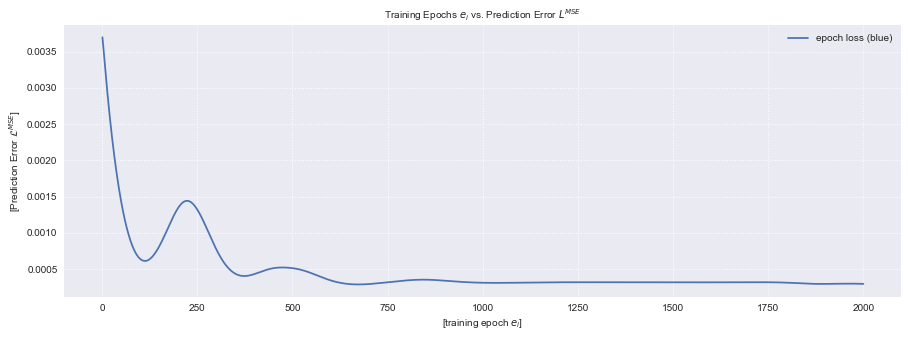

In [41]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{MSE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could definitely train the network a couple more epochs until the error converges. But let's stay with the 2'000 training epochs for now and continue with evaluating our trained model.

### Step 5.0. Evaluation of the Trained Neural Network Model

In this section we will conduct a visual comparison of the predicted daily returns to the actual ('true') daily returns. The comparison will encompass the daily returns of the in-sample time period as well as the returns of the out-of-sample time period.

#### Step 5.1. In-Sample Evaluation of the Trained Neural Network Model

Prior to evaluating our model let's load the best performing model or an already pre-trained model (as done below). Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load one of the (hopefully well performing) snapshots saved. 

In [42]:
model_name = 'awsome_lstm_model_12250.pth'
lstm_model.load_state_dict(torch.load(os.path.join("./models", model_name)))

Let's inspect if the model was loaded successfully: 

In [43]:
# set model in evaluation mode
lstm_model.eval()

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

Determine predictions of the in-sample population of sequences:

In [44]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(train_sequences_input)

    # collect prediction batch results
    predictions_list = predictions.detach().numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = train_sequences_target.numpy()[:, -1].tolist()

Plot the lstm neural network in-sample predictions vs. the actual "ground-truth" adjusted daily returns:

(array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15]),
 <a list of 8 Text yticklabel objects>)

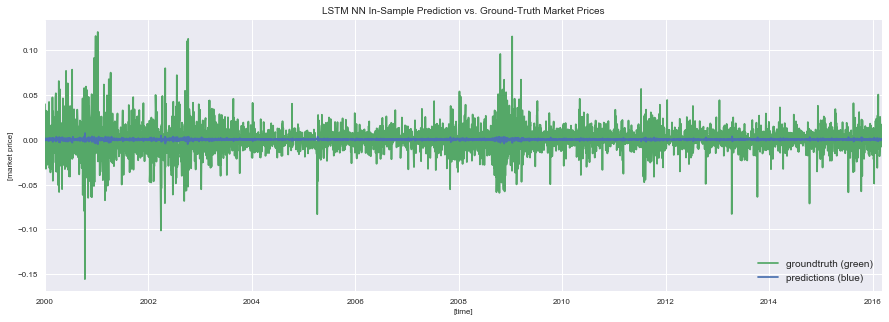

In [45]:
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(stock_data.index).values[0:train_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(stock_data.index).values[0:train_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(stock_data.index).values[0], pd.to_datetime(stock_data.index).values[train_sequences.shape[0]])

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN In-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

#### Step 5.2. Out-of-Sample Evaluation of the Trained Neural Network Model

Determine predictions of the out-of-sample population of sequences:

In [46]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(valid_sequences_input)

    # collect prediction batch results
    predictions_list = predictions.detach().numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = valid_sequences_target.numpy()[:, -1].tolist()

Plot the lstm neural network out-of-sample predictions vs. the actual "ground-truth" adjusted daily returns:

(array([-0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,
         0.1 ]), <a list of 10 Text yticklabel objects>)

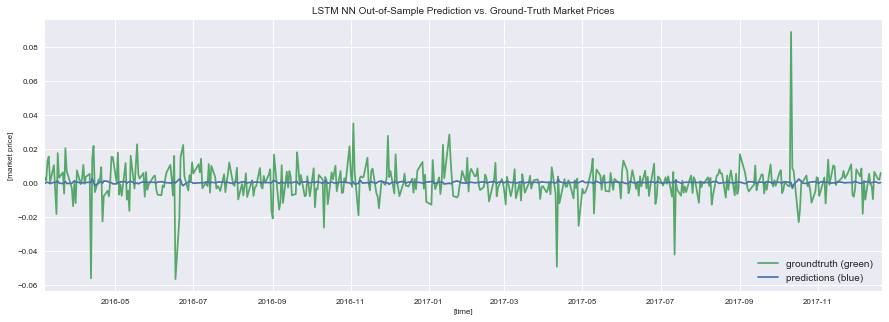

In [47]:
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]], pd.to_datetime(stock_data.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
#ax.set_ylim(0.0, 1.0)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN Out-of-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

### Step 6.0. Backtest of the Trained Neural Network Model

In this section we will backtest the python `bt` library. Python `bt` is a flexible backtest framework that can be used to test quantitative trading strategies. In general, backtesting is the process of testing a strategy over a given data set (more details about the `bt` library can be found via: https://pmorissette.github.io/bt/). 

In order to test the predictions derived from the LSTM model we will view its predictions as trade signals. Thereby, we will interpret any positive future return prediction $r_{t+1} > 0.0$ of a sequence $s$ as a "long" (buy) signal. Likewise, we will interpret any negative future return prediction $r_{t+1} < 0.0$ of a sequence $s$ as a "short" (sell) signal.

#### Step 6.1: LSTM Trading Signal Preparation

Let's start by converting the out-of-sample model predictions into a trading signal as described above. Therefore, we first convert the obtained predictions into a Pandas data frame:

In [48]:
stock_daily_predictions = pd.DataFrame(predictions_list, columns=['PREDICTIONS'])
stock_daily_predictions = stock_daily_predictions.set_index(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])

Furthermore, let's briefly ensure the successful conversion by inspecting the top 5 rows of the predictions:

In [49]:
stock_daily_predictions.head(10)

,PREDICTIONS
2016-03-07,-0.000208
2016-03-08,0.000183
2016-03-09,0.000474
2016-03-10,0.000090
2016-03-11,-0.000333
2016-03-14,0.000384
2016-03-15,0.000343
2016-03-16,0.000599
2016-03-17,0.001254
2016-03-18,-0.000068


Now, let's derive a trading signal from the converted predictions. As already described, we will generate the trading signal $\phi$ according to the following function:

<center>
$
\\
\phi(\hat{r}_{t+1})=
\begin{cases}
1.0, & for & \hat{r}_{t+1} > 0.0\\
-1.0, & for & \hat{r}_{t+1} < 0.0\\
\end{cases}
$
</center>

where $\hat{r}_{t+1}$ denotes a by the model predicted future return at time $t+1$.

In [50]:
signal_data = pd.DataFrame(np.where(stock_daily_predictions['PREDICTIONS'] > 0.0, 1.0, -1.0), columns=['SIGNAL'])
signal_data = signal_data.set_index(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])

Let's inspect the top 5 rows of the prepared trading signals:

In [51]:
signal_data.head(5)

,SIGNAL
2016-03-07,-1.0
2016-03-08,1.0
2016-03-09,1.0
2016-03-10,1.0
2016-03-11,-1.0


#### Step 6.2: Stock Market Data Preperation

Now, let's prepare the daily adjusted closing prices so that they can be utilized in the backtest:

In [52]:
stock_market_data = pd.DataFrame(stock_data['Adj. Close'])
stock_market_data = stock_market_data.rename(columns={'Adj. Close': 'PRICE'})
stock_market_data = stock_market_data.set_index(pd.to_datetime(stock_data.index))

Let's inspect the top 5 rows of the prepared adjusted closing prices:

In [53]:
stock_market_data.head(5)

,PRICE
Date,
2000-01-03,85.155442
2000-01-04,82.263093
2000-01-05,85.155442
2000-01-06,83.687245
2000-01-07,83.320195


Sub-sample the prepared daily adjusted closing prices to the out-of-sample time period:

In [54]:
stock_market_data = stock_market_data[stock_market_data.index >= stock_daily_predictions.index[0]]
stock_market_data = stock_market_data[stock_market_data.index <= stock_daily_predictions.index[-1]]

Visualize the out-of-sample daily adjusted closing prices:

Text(0.5, 1.0, 'International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices')

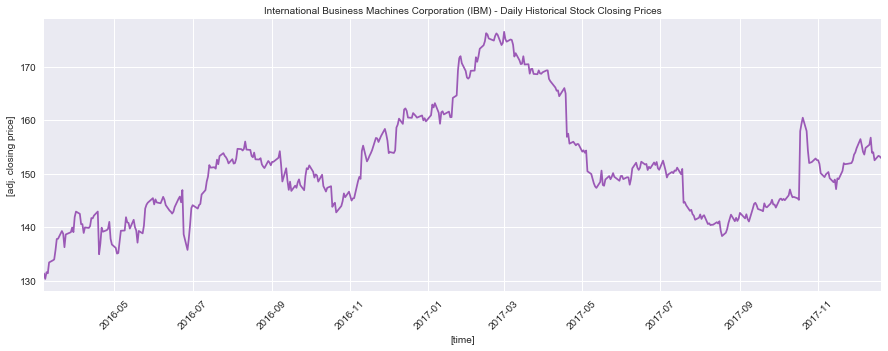

In [55]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(stock_market_data['PRICE'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
#ax.set_xlim(pd.to_datetime(stock_market_data.index).values[train_sequences.shape[0]], pd.to_datetime(stock_data.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
ax.set_ylabel('[equity %]', fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([stock_market_data.index[0], stock_market_data.index[-1]])
ax.set_ylabel('[adj. closing price]', fontsize=10)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices', fontsize=10)

Let's calculate our potential gained return by the application of a simple "buy and hold" strategy:

In [56]:
np.abs(stock_market_data.iloc[0]['PRICE'] - stock_market_data.iloc[-1]['PRICE']) / stock_market_data.iloc[0]['PRICE']

0.16479229590099914

#### Step 6.3. Backtest Preparation

Implement the "Moving Average" trading strategy:

In [57]:
class LSTMStrategy(bt.Algo):
    
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    def __call__(self, target):
        
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals.ix[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)
            
        # return True since we want to move on to the next timestep
        return True

Initialize our LSTM based trading strategy:

In [58]:
lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])

Initialize the backtest of our LSTM based trading strategy using the strategy and prepared market data:

In [59]:
backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')

In addition, let's also prepare a backtest of a "baseline" buy-and-hold trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal at each time step of the out-of-sample time frame: 

In [60]:
signal_data_base = signal_data.copy(deep=True) 
signal_data_base['SIGNAL'] = 1.0

Init the buy-and-hold ("base") strategy as well as the corresponding backtest:

In [61]:
base_strategy = bt.Strategy('base', [bt.algos.SelectAll(), LSTMStrategy(signal_data_base['SIGNAL']), bt.algos.Rebalance()])
backtest_base = bt.Backtest(strategy=base_strategy, data=stock_market_data, name='stock_base_backtest')

#### Step 6.4. Running the Backtest and Evaluate Results

Run the backtest for both trading strategies: 

In [62]:
backtest_results = bt.run(backtest_lstm, backtest_base)

stock_lstm_backtest
0% [############################# ] 100% | ETA: 00:00:00stock_base_backtest
0% [############################# ] 100% | ETA: 00:00:00

Inspect the individual backtest results and performance measures:

In [63]:
backtest_results.display()

Stat                 stock_lstm_backtest    stock_base_backtest
-------------------  ---------------------  ---------------------
Start                2016-03-06             2016-03-06
End                  2017-12-20             2017-12-20
Risk-free rate       0.00%                  0.00%

Total Return         143.78%                17.38%
Daily Sharpe         3.13                   0.62
Daily Sortino        7.03                   1.01
CAGR                 64.49%                 9.36%
Max Drawdown         -8.31%                 -21.65%
Calmar Ratio         7.76                   0.43

MTD                  6.16%                  -0.66%
3m                   35.03%                 5.89%
6m                   35.80%                 0.75%
YTD                  53.18%                 -4.28%
1Y                   50.96%                 -5.20%
3Y (ann.)            64.49%                 9.36%
5Y (ann.)            -                      -
10Y (ann.)           -                      -
Since Incep. 

Collect the LSTM trading strategy backtest details:

In [64]:
backtest_lstm_details = backtest_lstm.strategy.data
backtest_lstm_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

Inspect the LSTM trading strategy backtest details:

In [65]:
backtest_lstm_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2016-03-06,100.000000,1.000000e+06,1.000000e+06,0.0
2016-03-07,100.000000,1.000000e+06,1.000000e+06,0.0
2016-03-08,100.000000,1.000000e+06,8.487142e+01,0.0
2016-03-09,100.963462,1.009635e+06,8.487142e+01,0.0
2016-03-10,100.805281,1.008053e+06,8.487142e+01,0.0
2016-03-11,102.365514,1.023655e+06,2.047359e+06,0.0
2016-03-14,102.063494,1.020635e+06,6.474613e+01,0.0
2016-03-15,102.192156,1.021922e+06,6.474613e+01,0.0
2016-03-16,103.500213,1.035002e+06,6.474613e+01,0.0
2016-03-17,105.108479,1.051085e+06,6.474613e+01,0.0


Collect the "buy-and-hold" trading strategy backtest details:

In [66]:
backtest_base_details = backtest_base.strategy.data
backtest_base_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

Inspect the "buy-and-hold" trading strategy backtest details:

In [67]:
backtest_base_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2016-03-06,100.000000,1.000000e+06,1000000.000000,0.0
2016-03-07,100.000000,1.000000e+06,1000000.000000,0.0
2016-03-08,100.000000,1.000000e+06,84.871421,0.0
2016-03-09,100.963462,1.009635e+06,84.871421,0.0
2016-03-10,100.805281,1.008053e+06,84.871421,0.0
2016-03-11,102.365514,1.023655e+06,84.871421,0.0
2016-03-14,102.667495,1.026675e+06,84.871421,0.0
2016-03-15,102.796915,1.027969e+06,84.871421,0.0
2016-03-16,104.112688,1.041127e+06,84.871421,0.0
2016-03-17,105.730440,1.057304e+06,84.871421,0.0


Visualize the equity progression of both strategies over time:

Text(0.5, 1.0, 'International Business Machines Corporation (IBM) - Backtest % Equity Progression')

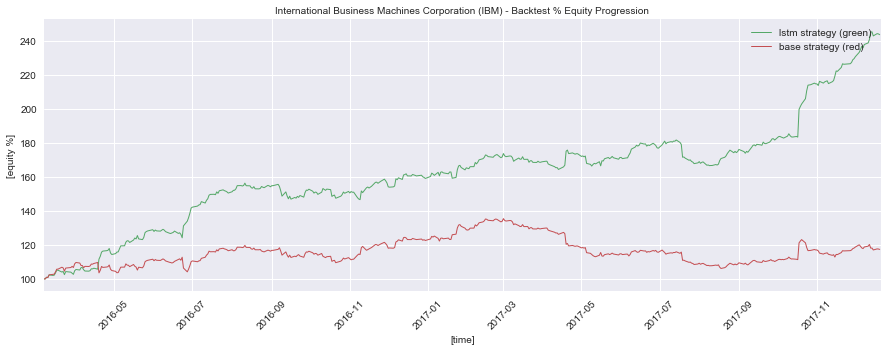

In [68]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(backtest_lstm_details['% EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')
ax.plot(backtest_base_details['% EQUITY'], color='C2',lw=1.0, label='base strategy (red)')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim(pd.to_datetime(stock_data.index).values[train_sequences.shape[0]], pd.to_datetime(stock_data.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
ax.set_ylabel('[equity %]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10)

### Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Evaluation of Shallow vs. Deep RNN Models.**

> Download the daily adjusted closing prices of the IBM stock within the time frame starting from 01/01/1990 until 05/31/2019. In addition to the architecture of the lab notebook, evaluate further (more shallow as well as more deep) RNN architectures by (1) either re- moving/adding layers of LSTM cells and/or (2) increasing/decreasing the dimensionality of the LSTM cells hidden state. Train your model (using architectures you selected) for at least 20'000 training epochs but keep the following parameters unchanged (a) sequence length: 5 time-steps (days) and (b) train vs. test fraction: 0.9.

> Analyze the prediction performance of the trained models in terms of training time and prediction accuracy. Furthermore, backtest the out-of-sample signals predicted by each of your models and evaluate them in terms of total return and equity progression. Which of your architecture results in the best performing model and why?

**2. Training and Evaluation of Models Learned from Additional Stocks.**

> Download the daily adjusted closing prices of at least two additional stocks (e.g., Alphabet, Deutsche Bank) within the time frame starting from 01/01/1990 until 05/31/2017. Pls. select two stocks that you are interested in to investigate ( e.g. stocks that you may occasionally trade yourself). Learn an ’optimal’ RNN model of both stocks and backtest their corresponding trade signals by following the approach outlined in the lab notebook regarding the IBM stock. Pls. keep the train vs. test dataset fraction fixed to 0.9, all other parameters of the data preparation and model training can be changed.

> Analyse the performance of the learned models in terms of their prediction accuracy as well as their out-of-sample backtest performance (e. g. the total return and equity progression). What architectures and corresponding training parameters result in the best performing models?

**3. Training and Evaluation of Models Learned from Augmented Data.**

> In the prior exercises we used the historical daily adjusted returns of a single stock to learn a model that can predict the stocks’ future adjusted closing price (log- return) movement. However, one of the advantages of NN’s lies in their capability to learn a model from multiple sources of input data.
For each of the two stocks (’target stocks’) that you selected in exercise 2. learn an ’optimal’ RNN model using the daily returns as a target label. However, prior to training your models augment the training data of each stock by the return sequences of at least three additional stocks. The additional stocks, used for data augmentation, should exhibit a high correlation to the historical adjusted closing prices of the target stock price movement you aim to model.

> Analyse the performance of the learned models in terms of their prediction accuracy as well as their out-of-sample backtest performance (e. g. the total return and equity progression). Do you observe an improvement of the trained model in terms of out-of-sample backtest performance comparison to exercise 1.?

### Lab Summary:

In this seventh lab, a step by step introduction into **design, implementation, training and evaluation** of a deep learning-based LSTM neural network based trading strategy is presented. 

The strategy trades a specific financial instrument based on its historical adjusted daily market prices. The degree of success of the implemented strategy is evaluated based in its backtest performance with particular focus on (1) the strategy's **total return** as well as (2) its **equity progression** over time. 

The code provided in this lab provides a blueprint for the development and testing of more complex trading strategies. It furthermore can be tailored to be applied for momentum trading of other financial instruments.

You may want to execute the content of your lab outside of the jupyter notebook environment e.g. on compute node or server. The cell below converts the lab notebook into a standalone and executable python script.

In [69]:
!jupyter nbconvert --to script cfds_lab_07.ipynb

[NbConvertApp] Converting notebook cfds_lab_07.ipynb to script
[NbConvertApp] Writing 39158 bytes to cfds_lab_07.py


**Note:** In order to execute the statement above and convert your lab notebook to a regular Python script you first need to install the nbconvert Python package e.g. using the pip package installer. 